TJ Wiegman  
ASM 591 AI  
Lab 8  
2024-11-08

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt


/home/tjw/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Solved Example 1: Basic RNN for Sequence Classification

### Objective

Build a simple RNN to classify sequences based on their cumulative sum. Sequences with a sum above a threshold belong to class 1; otherwise, class 0.

### Dataset

- **Input:** Sequences of real numbers.
- **Output:** Binary class label.


In [2]:
class SumDataset(Dataset):
    def __init__(self, num_samples=1000, seq_length=10):
        self.num_samples = num_samples
        self.seq_length = seq_length
        self.threshold = 0.0
        np.random.seed(0)
        self.data = np.random.randn(num_samples, seq_length)
        self.labels = (self.data.sum(axis=1) > self.threshold).astype(int)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        sequence = torch.tensor(self.data[idx], dtype=torch.float32).unsqueeze(-1)  # Shape: [seq_length, 1]
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return sequence, label


In [3]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, num_layers=1, num_classes=2):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)  # out: [batch, seq_length, hidden_size]

        # Take the output from the last time step
        out = out[:, -1, :]  # [batch, hidden_size]
        out = self.fc(out)
        return out


In [4]:
# Hyperparameters
input_size = 1
hidden_size = 16
num_layers = 1
num_classes = 2
num_epochs = 20
batch_size = 32
learning_rate = 0.001

# Dataset and DataLoader
dataset = SumDataset(num_samples=1000, seq_length=10)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model, Loss, Optimizer
model = SimpleRNN(input_size, hidden_size, num_layers, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(num_epochs):
    for sequences, labels in train_loader:
        outputs = model(sequences)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/20], Loss: 0.7510
Epoch [2/20], Loss: 0.5538
Epoch [3/20], Loss: 0.3179
Epoch [4/20], Loss: 0.2257
Epoch [5/20], Loss: 0.2377
Epoch [6/20], Loss: 0.6048
Epoch [7/20], Loss: 0.2674
Epoch [8/20], Loss: 0.0840
Epoch [9/20], Loss: 0.1239
Epoch [10/20], Loss: 0.2784
Epoch [11/20], Loss: 0.4390
Epoch [12/20], Loss: 0.0643
Epoch [13/20], Loss: 0.0522
Epoch [14/20], Loss: 0.0301
Epoch [15/20], Loss: 0.2004
Epoch [16/20], Loss: 0.1011
Epoch [17/20], Loss: 0.3430
Epoch [18/20], Loss: 0.0099
Epoch [19/20], Loss: 0.1442
Epoch [20/20], Loss: 0.0315


In [5]:
# Evaluation
with torch.no_grad():
    correct = 0
    total = 0
    for sequences, labels in train_loader:
        outputs = model(sequences)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total:.2f}%')


Accuracy: 97.00%


## Solved Example 2: LSTM with Hyperparameter Tuning

### Objective

Build an LSTM model to perform sentiment analysis on a simple dataset. Highlight how different hyperparameters impact model performance.

### Dataset

For simplicity, we'll create a synthetic dataset where sequences of positive numbers represent positive sentiment and sequences of negative numbers represent negative sentiment.


In [6]:
class SentimentDataset(Dataset):
    def __init__(self, num_samples=1000, seq_length=15):
        self.num_samples = num_samples
        self.seq_length = seq_length
        np.random.seed(1)
        # Positive samples
        pos_data = np.random.uniform(0.5, 1.5, size=(num_samples//2, seq_length))
        # Negative samples
        neg_data = np.random.uniform(-1.5, -0.5, size=(num_samples//2, seq_length))
        self.data = np.vstack((pos_data, neg_data))
        self.labels = np.hstack((np.ones(num_samples//2), np.zeros(num_samples//2))).astype(int)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        sequence = torch.tensor(self.data[idx], dtype=torch.float32).unsqueeze(-1)  # [seq_length, 1]
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return sequence, label


In [7]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2, num_classes=2, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: [batch, seq_length, hidden_size]

        # Take the output from the last time step
        out = out[:, -1, :]  # [batch, hidden_size]
        out = self.fc(out)
        return out


In [8]:
# Hyperparameters to experiment with
hidden_sizes = [16, 32, 64]
num_layers_list = [1, 2]

for hidden_size in hidden_sizes:
    for num_layers in num_layers_list:
        print(f'\nTraining LSTM with hidden_size={hidden_size}, num_layers={num_layers}')

        model = LSTMModel(input_size=1, hidden_size=hidden_size, num_layers=num_layers, num_classes=2, dropout=0.3)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Dataset and DataLoader
        dataset = SentimentDataset(num_samples=1000, seq_length=15)
        train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

        # Training Loop
        num_epochs = 15
        for epoch in range(num_epochs):
            for sequences, labels in train_loader:
                outputs = model(sequences)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Evaluation
        with torch.no_grad():
            correct = 0
            total = 0
            for sequences, labels in train_loader:
                outputs = model(sequences)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            print(f'Accuracy: {accuracy:.2f}%')



Training LSTM with hidden_size=16, num_layers=1


/home/tjw/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Accuracy: 100.00%

Training LSTM with hidden_size=16, num_layers=2
Accuracy: 100.00%

Training LSTM with hidden_size=32, num_layers=1
Accuracy: 100.00%

Training LSTM with hidden_size=32, num_layers=2
Accuracy: 100.00%

Training LSTM with hidden_size=64, num_layers=1
Accuracy: 100.00%

Training LSTM with hidden_size=64, num_layers=2
Accuracy: 100.00%


## Solved Example 3: GRU with Feature Extraction

### Objective

Implement a GRU-based model to predict the next value in a time series, highlighting the role of feature extraction.


In [9]:
class SineWaveDataset(Dataset):
    def __init__(self, num_samples=1000, seq_length=50):
        self.num_samples = num_samples
        self.seq_length = seq_length
        self.x = np.linspace(0, 100, num_samples + seq_length)
        self.y = np.sin(self.x) + 0.1 * np.random.randn(len(self.x))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        sequence = self.y[idx:idx + self.seq_length]
        target = self.y[idx + self.seq_length]
        sequence = torch.tensor(sequence, dtype=torch.float32).unsqueeze(-1)  # [seq_length, 1]
        target = torch.tensor(target, dtype=torch.float32)
        return sequence, target


In [10]:
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, output_size=1, kernel_size=3):
        super(GRUModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=kernel_size, padding=1)
        self.relu = nn.ReLU()
        self.gru = nn.GRU(input_size=16, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: [batch, seq_length, 1]
        x = x.permute(0, 2, 1)  # [batch, 1, seq_length]
        x = self.conv1(x)       # [batch, 16, seq_length]
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # [batch, seq_length, 16]
        out, _ = self.gru(x)
        out = out[:, -1, :]     # [batch, hidden_size]
        out = self.fc(out)
        return out


In [11]:
# Hyperparameters
input_size = 1
hidden_size = 32
num_layers = 1
output_size = 1
kernel_size = 3
num_epochs = 30
batch_size = 64
learning_rate = 0.001

# Dataset and DataLoader
dataset = SineWaveDataset(num_samples=1000, seq_length=50)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model, Loss, Optimizer
model = GRUModel(input_size, hidden_size, num_layers, output_size, kernel_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(num_epochs):
    for sequences, targets in train_loader:
        outputs = model(sequences)
        loss = criterion(outputs.squeeze(), targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [5/30], Loss: 0.0237
Epoch [10/30], Loss: 0.0144
Epoch [15/30], Loss: 0.0138
Epoch [20/30], Loss: 0.0095
Epoch [25/30], Loss: 0.0097
Epoch [30/30], Loss: 0.0142


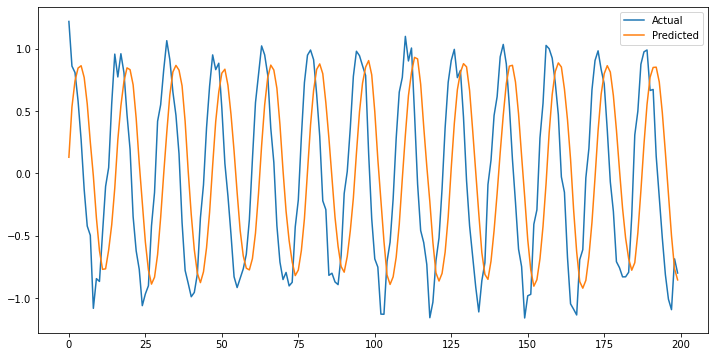

In [12]:
# Evaluation on a new sine wave
model.eval()
with torch.no_grad():
    test_dataset = SineWaveDataset(num_samples=200, seq_length=50)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    predictions = []
    actual = []
    for sequences, targets in test_loader:
        output = model(sequences)
        predictions.append(output.item())
        actual.append(targets.item())

# Plotting
plt.figure(figsize=(12,6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()


## Solved Example 4: Combining CNN and LSTM for Text Classification

### Objective

Build a text classification model that first uses a Convolutional Neural Network (CNN) for feature extraction from text embeddings, followed by an LSTM to capture sequential dependencies.


In [16]:
import torchtext
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# Tokenizer and Vocabulary
tokenizer = get_tokenizer('basic_english')
train_iter = IMDB(split='train')

def yield_tokens(data_iter):
    for label, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Reload train_iter
train_iter = IMDB(split='train')

# Encoding function
def encode(text):
    return vocab(tokenizer(text))

# Dataset Class
class IMDBDatasetCustom(Dataset):
    def __init__(self, split='train'):
        self.data = list(IMDB(split=split))
        self.labels = [1 if label == 'pos' else 0 for label, _ in self.data]
        self.texts = [encode(text) for _, text in self.data]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        return torch.tensor(text, dtype=torch.long), torch.tensor(label, dtype=torch.long)


TypeError: IMDB.__init__() missing 3 required positional arguments: 'path', 'text_field', and 'label_field'

In [17]:
class CNNLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size=128, cnn_out_channels=64, cnn_kernel_size=5,
                 lstm_hidden_size=128, lstm_num_layers=2, num_classes=2, dropout=0.5):
        super(CNNLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.conv = nn.Conv1d(in_channels=embed_size, out_channels=cnn_out_channels, kernel_size=cnn_kernel_size, padding=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(input_size=cnn_out_channels, hidden_size=lstm_hidden_size,
                            num_layers=lstm_num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, x, lengths):
        # x: [batch, seq_length]
        embedded = self.embedding(x)  # [batch, seq_length, embed_size]
        embedded = embedded.permute(0, 2, 1)  # [batch, embed_size, seq_length]
        conv_out = self.conv(embedded)  # [batch, cnn_out_channels, seq_length]
        conv_out = self.relu(conv_out)
        conv_out = conv_out.permute(0, 2, 1)  # [batch, seq_length, cnn_out_channels]
        conv_out = self.dropout(conv_out)

        # Pack sequence
        packed_input = nn.utils.rnn.pack_padded_sequence(conv_out, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hn, cn) = self.lstm(packed_input)
        # Use the last hidden state
        out = self.fc(hn[-1])  # [batch, num_classes]
        return out


In [18]:
# Collate Function with Padding
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    texts, labels = zip(*batch)
    lengths = [len(text) for text in texts]
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0)
    return texts_padded, torch.tensor(labels, dtype=torch.long), torch.tensor(lengths, dtype=torch.long)


In [19]:
# Hyperparameters
vocab_size = len(vocab)
embed_size = 128
cnn_out_channels = 64
cnn_kernel_size = 5
lstm_hidden_size = 128
lstm_num_layers = 2
num_classes = 2
dropout = 0.5
num_epochs = 5
batch_size = 64
learning_rate = 0.001

# Dataset and DataLoader
train_dataset = IMDBDatasetCustom(split='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

# Model, Loss, Optimizer
model = CNNLSTMModel(vocab_size, embed_size, cnn_out_channels, cnn_kernel_size,
                    lstm_hidden_size, lstm_num_layers, num_classes, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for texts, labels, lengths in train_loader:
        outputs = model(texts, lengths)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


NameError: name 'vocab' is not defined

In [20]:
# Evaluation on test set
test_dataset = IMDBDatasetCustom(split='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for texts, labels, lengths in test_loader:
        outputs = model(texts, lengths)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Test Accuracy: {100 * correct / total:.2f}%')


NameError: name 'IMDBDatasetCustom' is not defined

## Problem Set

### Problem 1: Building a Bidirectional RNN for Sequence Labeling

**Task:** Implement a bidirectional RNN using PyTorch to perform part-of-speech tagging on a synthetic dataset. Compare its performance with a unidirectional RNN.

**Requirements:**
- Create a synthetic dataset where each word is associated with a POS tag.
- Implement both unidirectional and bidirectional RNN models.
- Evaluate and compare their accuracies.


In [35]:
DEP = [
    "pnv", # preposition, noun, verb
    "pnvn", # + noun
    "pnvan", # + adjective, noun
    "panv", # preposition, adjective, noun
    "panvan", # + adjective, noun
    "vpn", # verb, prep, noun
    "vpan", # + adjective, noun
    "pan" # prep, adjective, noun
]
IND = [
    "nv", # noun, verb
    "anv", # adjective, noun, verb
    "nvpn", # noun, verb, prep, noun
    "nvpan", # + adjective, noun
    "anvpan", # adjective +
    "anvpn", # adjective + nvpn
]

TYPES = {0: "simple", 1: "compound", 2: "complex", 3: "compound-complex"}
CODES = {
    "a": 1, # adjective
    "c": 2, # conjunction
    "n": 3, # noun
    "p": 4, # preposition
    "v": 5, # verb
    0: "-"  # padding
}


class PosDataset(Dataset):
    def __init__(self, num_samples=1000, max_words=20):
        self.num_samples = num_samples
        self.seq_length = max_words
        np.random.seed(1)
        
        self.data = []
        self.labels = []
        # Build sentences one phrase at a time
        for _ in range(num_samples):
            label = ""
            t = np.random.randint(0, 4)
            if TYPES[t] == "simple":
                label += np.random.choice(IND)
            elif TYPES[t] == "compound":
                label += np.random.choice(IND)
                label += "c" # conjunction
                label += np.random.choice(IND)
            elif TYPES[t] == "complex":
                if np.random.randint(0, 2) == 0:    # DI
                    label += np.random.choice(DEP)
                    label += np.random.choice(IND)
                else:                               # ID
                    label += np.random.choice(IND)
                    label += np.random.choice(DEP)
            else: # compound-complex
                t = np.random.randint(0,3)
                if t == 0: # DII
                    label += np.random.choice(DEP)
                    label += np.random.choice(IND)
                    label += "c"
                    label += np.random.choice(IND)
                elif t == 1: # IDI
                    label += np.random.choice(IND)
                    label += np.random.choice(DEP)
                    label += "c"
                    label += np.random.choice(IND)
                elif t == 2: # IID
                    label += np.random.choice(IND)
                    label += "c"
                    label += np.random.choice(IND)
                    label += np.random.choice(DEP)
            
            # Encode sentences as numbers
            data = [CODES[word] + np.random.uniform(-0.5, 0.5) for word in label]
            outl = [CODES[word] for word in label]
            
            # Pad every sentence to same length
            while len(data) < max_words:
                data.append(0)
                outl.append(0)
            
            # Save encoded sequences to dataset
            self.data.append(data)
            self.labels.append(outl)
        

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        sequence = torch.tensor(self.data[idx], dtype=torch.float32).unsqueeze(-1)  # [seq_length, 1]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return sequence, label


In [45]:
class UniRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, num_layers=1, num_classes=2):
        super(UniRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True,
                          nonlinearity='relu', bidirectional=False)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)  # out: [batch, seq_length, hidden_size]

        # Take the output from the last time step
        out = out[:, -1, :]  # [batch, hidden_size]
        out = self.fc(out)
        return out

class BiRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, num_layers=1, num_classes=2):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True,
                          nonlinearity='relu', bidirectional=True)
        self.fc = nn.Linear(2*hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(2*self.num_layers, x.size(0), self.hidden_size)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)  # out: [batch, seq_length, hidden_size]

        # Take the output from the last time step
        out = out[:, -1, :]  # [batch, hidden_size]
        out = self.fc(out)
        return out


In [66]:
# Hyperparameters
input_size = 1
hidden_size = 16
num_layers = 1
num_classes = 20
num_epochs = 20
batch_size = 32
learning_rate = 0.001

# Dataset and DataLoader
dataset = PosDataset()
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model, Loss, Optimizer
unimodel = UniRNN(input_size, hidden_size, num_layers, num_classes)
bimodel = BiRNN(input_size, hidden_size, num_layers, num_classes)
criterion = nn.functional.mse_loss
optimizer1 = optim.Adam(unimodel.parameters(), lr=learning_rate)
optimizer2 = optim.Adam(bimodel.parameters(), lr=learning_rate)

# Log data for later
losses1 = []
losses2 = []

# Training Loop
for epoch in range(num_epochs+1):
    for sequences, labels in train_loader:
        # Train unidirectional model
        output1 = unimodel(sequences)
        loss1 = criterion(output1, labels)
        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()
        
        # Train bidirectional model
        output2 = bimodel(sequences)
        loss2 = criterion(output2, labels)
        optimizer2.zero_grad()
        loss2.backward()
        optimizer2.step()
    
    losses1.append(loss1.item())
    losses2.append(loss2.item())
    print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss1.item():.04f} & {loss2.item():.04f}')


Epoch [0/20], Loss: 6.0240 & 5.7290
Epoch [1/20], Loss: 5.5259 & 4.3549
Epoch [2/20], Loss: 2.5586 & 1.8759
Epoch [3/20], Loss: 1.6301 & 1.6065
Epoch [4/20], Loss: 1.8674 & 1.7954
Epoch [5/20], Loss: 1.4447 & 1.4442
Epoch [6/20], Loss: 1.8008 & 1.7296
Epoch [7/20], Loss: 1.7762 & 1.6295
Epoch [8/20], Loss: 1.9124 & 1.6375
Epoch [9/20], Loss: 1.5874 & 1.3499
Epoch [10/20], Loss: 1.4197 & 0.8907
Epoch [11/20], Loss: 1.3542 & 0.8563
Epoch [12/20], Loss: 1.5907 & 1.0799
Epoch [13/20], Loss: 1.2280 & 0.7768
Epoch [14/20], Loss: 1.6095 & 0.9962
Epoch [15/20], Loss: 1.2726 & 0.8408
Epoch [16/20], Loss: 1.5008 & 1.1573
Epoch [17/20], Loss: 1.8228 & 1.1210
Epoch [18/20], Loss: 1.3807 & 0.7283
Epoch [19/20], Loss: 1.7197 & 1.0878
Epoch [20/20], Loss: 1.5491 & 1.0205


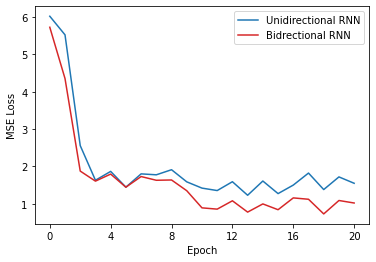

In [67]:
plt.plot(losses1, color="tab:blue", label="Unidirectional RNN")
plt.plot(losses2, color="tab:red", label="Bidrectional RNN")
plt.legend()

plt.ylabel("MSE Loss")

plt.xticks(range(0, num_epochs+1, num_epochs // 5), range(0, num_epochs+1, num_epochs // 5))
plt.xlabel("Epoch")

plt.show()

In [68]:
# The Bidirectional RNN converges to more accurate answers
# faster than the Unidirectional RNN does.



### Problem 2: Exploring Hyperparameter Effects on LSTM Performance

**Task:** Using the SentimentDataset from Solved Example 2, train multiple LSTM models with varying hyperparameters (e.g., hidden size, number of layers, dropout). Analyze how these hyperparameters affect the model's ability to generalize.

**Requirements:**
- Experiment with at least three different hidden sizes and two different numbers of layers.
- Plot training and validation accuracies for each configuration.
- Provide insights on the optimal hyperparameter settings based on your observations.


In [89]:
num_epochs = 8
learning_rate = 0.0001
accuracies = {}

for hidden_size in [2, 3, 4, 5]:
    for num_layers in [2, 4]:
        # Prepare model + dataset
        print(f'Training LSTM with {hidden_size=} & {num_layers=}')
        model = LSTMModel(1,hidden_size, num_layers)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        dataset = SentimentDataset(num_samples=5000)
        train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
        
        accuracies[(hidden_size, num_layers)] = {}
        
        # Training
        for epoch in range(num_epochs):
            correct = 0
            total = 0
            for sequences, labels in train_loader:
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            accuracy = 100 * correct / total
            print(f"\r[{epoch+1}/{num_epochs}] Training " + 
                  f"{(hidden_size, num_layers)}... " +
                  f"({accuracy:.2f}% accurate)", end="")
        
        accuracies[(hidden_size, num_layers)]["training"] = accuracy
        
        # Testing
        with torch.no_grad():
            correct = 0
            total = 0
            for sequences, labels in train_loader:
                outputs = model(sequences)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            print(f'\n {(hidden_size, num_layers)} Testing Accuracy: {accuracy:.2f}%')
        
        accuracies[(hidden_size, num_layers)]["testing"] = accuracy


Training LSTM with hidden_size=2 & num_layers=2
[8/8] Training (2, 2)... (50.00% accurate)
 (2, 2) Testing Accuracy: 50.00%
Training LSTM with hidden_size=2 & num_layers=4
[8/8] Training (2, 4)... (50.00% accurate)
 (2, 4) Testing Accuracy: 50.00%
Training LSTM with hidden_size=3 & num_layers=2
[8/8] Training (3, 2)... (87.94% accurate)
 (3, 2) Testing Accuracy: 88.42%
Training LSTM with hidden_size=3 & num_layers=4
[8/8] Training (3, 4)... (50.00% accurate)
 (3, 4) Testing Accuracy: 50.64%
Training LSTM with hidden_size=4 & num_layers=2
[8/8] Training (4, 2)... (50.00% accurate)
 (4, 2) Testing Accuracy: 50.00%
Training LSTM with hidden_size=4 & num_layers=4
[8/8] Training (4, 4)... (99.86% accurate)
 (4, 4) Testing Accuracy: 99.98%
Training LSTM with hidden_size=5 & num_layers=2
[8/8] Training (5, 2)... (100.00% accurate)
 (5, 2) Testing Accuracy: 100.00%
Training LSTM with hidden_size=5 & num_layers=4
[8/8] Training (5, 4)... (99.98% accurate)
 (5, 4) Testing Accuracy: 100.00%


In [90]:
y = [0]
train_bars = []
test_bars = []
for key in accuracies:
    train_bars.append(accuracies[key]["training"])
    test_bars.append(accuracies[key]["testing"])
    y.append(y[-1]+1)
y.pop()
print(f"{train_bars=}")
print(f"{test_bars=}")


train_bars=[50.0, 50.0, 87.94, 50.0, 50.0, 99.86, 100.0, 99.98]
test_bars=[50.0, 50.0, 88.42, 50.64, 50.0, 99.98, 100.0, 100.0]


Text(0.5, 1.0, 'Training Accuracy of LSTM Models')

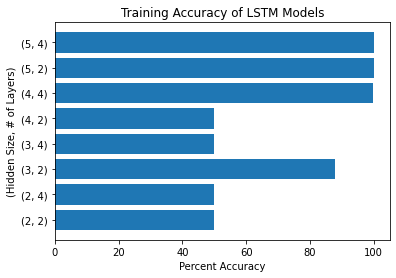

In [91]:
plt.barh(y, train_bars)
plt.yticks(y, list(accuracies.keys()))
plt.ylabel("(Hidden Size, # of Layers)")
plt.xlabel("Percent Accuracy")
plt.title("Training Accuracy of LSTM Models")

Text(0.5, 1.0, 'Testing Accuracy of LSTM Models')

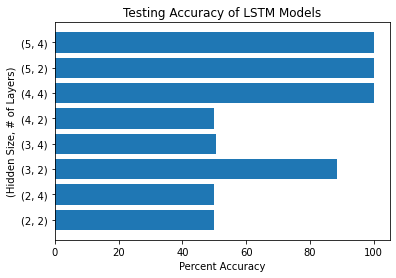

In [93]:
plt.barh(y, test_bars)
plt.yticks(y, list(accuracies.keys()))
plt.ylabel("(Hidden Size, # of Layers)")
plt.xlabel("Percent Accuracy")
plt.title("Testing Accuracy of LSTM Models")

In [ ]:
# Based on the results shown above, the accuracy seems to scale more with hidden
# size than number of layers, but both are important. The smallest model that
# still has excellent performance is 4 hidden layers with 4 nodes each.


### Problem 3: GRU for Multivariate Time Series Forecasting

**Task:** Apply a GRU model to a multivariate time series dataset (e.g., predicting stock prices using multiple indicators). Highlight the importance of feature extraction in handling multiple input features.

**Requirements:**
- Choose a real-world multivariate time series dataset.
- Preprocess the data and create appropriate input sequences.
- Implement a GRU model to predict the next value of one of the series.
- Discuss how feature extraction (e.g., normalization, dimensionality reduction) impacts model performance.


In [149]:
from sklearn.datasets import fetch_openml

bike_demand = fetch_openml(
    "Kaggle_bike_sharing_demand_challange", version=1, as_frame=True, parser="pandas"
)

bike_demand.data

,time,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,dayOfWeek
0,00:00:00,1,0,0,1,9.84,14.395,81,0.000,zaterdag
1,01:00:00,1,0,0,1,9.02,13.635,80,0.000,zaterdag
2,02:00:00,1,0,0,1,9.02,13.635,80,0.000,zaterdag
3,03:00:00,1,0,0,1,9.84,14.395,75,0.000,zaterdag
4,04:00:00,1,0,0,1,9.84,14.395,75,0.000,zaterdag
...,...,...,...,...,...,...,...,...,...,...
10881,19:00:00,4,0,1,1,15.58,19.695,50,260.027,vrijdag
10882,20:00:00,4,0,1,1,14.76,17.425,57,150.013,vrijdag
10883,21:00:00,4,0,1,1,13.94,15.910,61,150.013,vrijdag
10884,22:00:00,4,0,1,1,13.94,17.425,61,60.032,vrijdag


In [189]:
# Int: Targets
print(type(bike_demand.target[0]))
print(f"{bike_demand.target.min()} - {bike_demand.target.max()}")

<class 'numpy.int64'>
1 - 977


In [148]:
# Int: Hour of day
print(type(bike_demand.data["time"][0]))
print(bike_demand.data["time"].unique().tolist())

<class 'str'>
['00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00', '06:00:00', '07:00:00', '08:00:00', '09:00:00', '10:00:00', '11:00:00', '12:00:00', '13:00:00', '14:00:00', '15:00:00', '16:00:00', '17:00:00', '18:00:00', '19:00:00', '20:00:00', '21:00:00', '22:00:00', '23:00:00']


In [152]:
# Int: Season of year (spring, summer, fall, winter)
print(type(bike_demand.data["season"][0]))
print(bike_demand.data["season"].unique().tolist())

<class 'str'>
['1', '2', '3', '4']


In [154]:
# Bool: If day is holiday or not
print(type(bike_demand.data["holiday"][0]))
print(bike_demand.data["holiday"].unique().tolist())

<class 'str'>
['0', '1']


In [155]:
# Bool: If day is not a weekend or holiday
print(type(bike_demand.data["workingday"][0]))
print(bike_demand.data["workingday"].unique().tolist())

<class 'str'>
['0', '1']


In [156]:
# Int: Hourly weather (clear, mist/fog, rain/snow, heavy rain/hail)
print(type(bike_demand.data["weather"][0]))
print(bike_demand.data["weather"].unique().tolist())

<class 'str'>
['1', '2', '3', '4']


In [160]:
# Float: Temp in C
print(type(bike_demand.data["temp"][0]))
print(f'{bike_demand.data["temp"].min():0.2f} - {bike_demand.data["temp"].max():0.2f}')

<class 'numpy.float64'>
0.82 - 41.00


In [161]:
# Float: Apparent temp in C
print(type(bike_demand.data["atemp"][0]))
print(f'{bike_demand.data["atemp"].min():0.2f} - {bike_demand.data["atemp"].max():0.2f}')

<class 'numpy.float64'>
0.76 - 45.45


In [166]:
# Int: Humidity
print(type(bike_demand.data["humidity"][0]))
print(f'{bike_demand.data["humidity"].min()} - {bike_demand.data["humidity"].max()}')

<class 'numpy.int64'>
0 - 100


In [165]:
# Float: Wind speed (no units given)
print(type(bike_demand.data["windspeed"][0]))
print(f'{bike_demand.data["windspeed"].min():0.2f} - {bike_demand.data["windspeed"].max():0.2f}')

<class 'numpy.float64'>
0.00 - 569.97


In [172]:
# Int: Day of week
translate = {
    "zondag": 0,    # sunday
    "maandag": 1,   # monday
    "dinsdag": 2,   # tuesday
    "woensdag": 3,  # wednesday
    "donderdag": 4, # thursday
    "vrijdag": 5,   # friday
    "zaterdag": 6   # saturday
}
print(" | ".join([str(translate[day]) for day in bike_demand.data["dayOfWeek"].unique()]))

6 | 0 | 1 | 2 | 4 | 5 | 3


In [181]:
bike_data = torch.zeros(bike_demand.data.shape, dtype=torch.float)

for i in range(bike_demand.data.shape[0]):
    bike_data[i,0] = int(bike_demand.data["time"][i][:2])
    bike_data[i,1] = int(bike_demand.data["season"][i])
    bike_data[i,2] = int(bike_demand.data["holiday"][i])
    bike_data[i,3] = int(bike_demand.data["workingday"][i])
    bike_data[i,4] = int(bike_demand.data["weather"][i])
    bike_data[i,5] = bike_demand.data["temp"][i]
    bike_data[i,6] = bike_demand.data["atemp"][i]
    bike_data[i,7] = bike_demand.data["humidity"][i]
    bike_data[i,8] = bike_demand.data["windspeed"][i]
    bike_data[i,9] = translate[bike_demand.data["dayOfWeek"][i]]
    
bike_data

tensor([[  0.0000,   1.0000,   0.0000,  ...,  81.0000,   0.0000,   6.0000],
        [  1.0000,   1.0000,   0.0000,  ...,  80.0000,   0.0000,   6.0000],
        [  2.0000,   1.0000,   0.0000,  ...,  80.0000,   0.0000,   6.0000],
        ...,
        [ 21.0000,   4.0000,   0.0000,  ...,  61.0000, 150.0130,   5.0000],
        [ 22.0000,   4.0000,   0.0000,  ...,  61.0000,  60.0320,   5.0000],
        [ 23.0000,   4.0000,   0.0000,  ...,  66.0000,  89.9810,   5.0000]])

In [196]:
bike_target = torch.tensor(bike_demand.target)
bike_target

tensor([ 16,  40,  32,  ..., 168, 129,  88])

In [402]:
# Simple 1-D normalization class
class CustomScaler():
    def fit_transform(self, tensor):
        self.offset = torch.mean(tensor, dtype=torch.float)
        self.var = torch.var(tensor)
        return (tensor - self.offset) / self.var
    
    def inverse_transform(self, tensor):
        return (self.var * tensor) + self.offset

In [403]:
# Create datasets
from torch.utils.data import Dataset, DataLoader
from random import sample

class BikeSet(Dataset):
    def __init__(self, data, targets, ids):
        self.X = torch.zeros(size=(len(ids), data.shape[1]), dtype=torch.float)
        self.y = torch.zeros(len(ids))
        
        for i in range(len(ids)):
            self.X[i,:] = data[ids[i],:]
            self.y[i] = targets[ids[i]]
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]
    
class BikeSetNorm(Dataset):
    def __init__(self, data, targets, ids):
        self.X = torch.zeros(size=(len(ids), data.shape[1]), dtype=torch.float)
        self.y = torch.zeros(len(ids))
        
        for i in range(len(ids)):
            self.X[i,:] = data[ids[i],:]
            self.y[i] = targets[ids[i]]
            
        # Normalize each column of dataset
        self.scalers = []
        for j in range(self.X.shape[1]):
            self.scalers.append(CustomScaler())
            self.X[:,j] = self.scalers[j].fit_transform(self.X[:,j].float())
        
        # Normalize targets too
        self.scalers.append(CustomScaler())
        self.y = self.scalers[-1].fit_transform(self.y.float())
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]


In [404]:
# Prepare data loaders
N = len(bike_target)
testN = int(0.2*N)
test_ids = sample(range(N), testN)
train_ids = [i for i in range(N) if i not in test_ids]

# Create datasets
train_set3 = BikeSet(
    data = bike_data,
    targets = bike_target,
    ids = train_ids
)
test_set3 = BikeSet(
    data = bike_data,
    targets = bike_target,
    ids = test_ids
)

# Create data loaders
train_data3 = DataLoader(
    dataset = train_set3,
    batch_size = 20,
    shuffle = True
)
test_data3 = DataLoader(
    dataset = test_set3,
    batch_size = 50,
    shuffle = True
)


In [405]:
# Create NORMALIZED datasets
train_set3n = BikeSetNorm(
    data = bike_data,
    targets = bike_target,
    ids = train_ids
)
test_set3n = BikeSetNorm(
    data = bike_data,
    targets = bike_target,
    ids = test_ids
)

# Create NORMALIZED data loaders
train_data3n = DataLoader(
    dataset = train_set3n,
    batch_size = 20,
    shuffle = True
)
test_data3n = DataLoader(
    dataset = test_set3n,
    batch_size = 50,
    shuffle = True
)


In [406]:
# Create training function
def train(epoch, model, device, optimizer, data, loss_function):
    # Prepare model
    model.to(device)
    model.train()
    
    for batch_idx, (X, y) in enumerate(data):
        # Load data into `device`
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        
        # Calculate and record output & loss
        output = model(X).reshape(-1)
        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()
        
        # Periodically report on training progress
        print(f"\rEpoch {epoch}: Training {batch_idx * len(X)}/{len(data.dataset)} " + 
              f"(Loss: {loss.item():02.4})", end=" "*10)
    print(f"\rEpoch {epoch}: Trained {len(data.dataset)}/{len(data.dataset)} " + 
              f"(Loss: {loss.item():02.4})" + " "*10)

In [407]:
# Create testing function
def test(epoch, model, device, data, loss_function):
    # Prepare model and data
    model.to(device)
    model.eval()
    test_loss = []
    map = []
    
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(data):
            # Load data into `device`
            X = X.to(device)
            y = y.to(device)
            
            # Calculate and record output & loss
            output = model(X).reshape(-1)
            test_loss.append(loss_function(output, y).item())
            map.append(torch.mean(torch.abs((output - y) / y)) * 100)
            
            # Periodically report on testing progress
            print(f"\rEpoch {epoch}: Testing {batch_idx*len(X)}/{len(data.dataset)}...", end="")
        print(f"\rEpoch {epoch}: Testing {len(data.dataset)}/{len(data.dataset)}")
    
    # Report results
    test_loss = torch.mean(torch.tensor(test_loss))
    accuracy = torch.mean(torch.tensor(map))
    print(f"Test Result, epoch {epoch}: Avg loss {test_loss:04.4}, MAPE {accuracy:02.4}%")
    
    return accuracy

In [408]:
# Create NN
import torch.nn as nn
import torch.nn.functional as F

class Problem3Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.hsize = 24
        hlayers = 10
        self.nn1 = nn.GRU(10, self.hsize, hlayers, batch_first=True)
        self.nn2 = nn.Linear(self.hsize, 1)
    
    def forward(self, x):
        x, _ = self.nn1(x)
        x = F.relu(x)
        x = self.nn2(x)
        return x


In [1]:
# Enable GPU acceleration
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [411]:
# Train models on either dataset or normalized dataset
MAX_EPOCHS = 20
p3net = Problem3Net()
optimizer = torch.optim.Adam(p3net.parameters(), lr=0.01)
p3netNORM = Problem3Net()
optimNORM = torch.optim.Adam(p3netNORM.parameters(), lr=0.01)

for epoch in range(1, MAX_EPOCHS+1):
    # Non-normalized data
    print("-"*10 + "  UNSCALED  " + "-"*10)
    train(
        epoch = epoch,
        model = p3net,
        device = device,
        optimizer = optimizer,
        data = train_data3,
        loss_function = F.mse_loss
    )
    test(
        epoch = epoch,
        model = p3net,
        device = device,
        data = test_data3,
        loss_function = F.mse_loss
    )
    
    # Normalized data
    print("-"*10 + " NORMALIZED " + "-"*10)
    train(
        epoch = epoch,
        model = p3netNORM,
        device = device,
        optimizer = optimNORM,
        data = train_data3n,
        loss_function = F.mse_loss
    )
    test(
        epoch = epoch,
        model = p3netNORM,
        device = device,
        data = test_data3n,
        loss_function = F.mse_loss
    )
    print("="*52)

----------  UNSCALED  ----------
Epoch 1: Trained 8709/8709 (Loss: 4.726e+04)           
Epoch 1: Testing 2177/2177...
Test Result, epoch 1: Avg loss 5.687e+04, MAPE 154.7%
---------- NORMALIZED ----------
Epoch 1: Trained 8709/8709 (Loss: 1.621e-05)           
Epoch 1: Testing 2177/2177...
Test Result, epoch 1: Avg loss 3.626e-05, MAPE 429.4%
----------  UNSCALED  ----------
Epoch 2: Trained 8709/8709 (Loss: 6.563e+03)           
Epoch 2: Testing 2177/2177...
Test Result, epoch 2: Avg loss 4.843e+04, MAPE 250.6%
---------- NORMALIZED ----------
Epoch 2: Trained 8709/8709 (Loss: 3.863e-05)           
Epoch 2: Testing 2177/2177...
Test Result, epoch 2: Avg loss 3.584e-05, MAPE 391.3%
----------  UNSCALED  ----------
Epoch 3: Trained 8709/8709 (Loss: 4.725e+04)           
Epoch 3: Testing 2177/2177...
Test Result, epoch 3: Avg loss 4.22e+04, MAPE 342.7%
---------- NORMALIZED ----------
Epoch 3: Trained 8709/8709 (Loss: 3.566e-05)           
Epoch 3: Testing 2177/2177...
Test Result, epoc

In [412]:
# Models trained on normalized data seem to converge better and faster than 
# models trained on unscaled data.


### Problem 4: Integrating CNN and LSTM for Video Classification

**Task:** Design a model that uses a Convolutional Neural Network (CNN) to extract spatial features from video frames and an LSTM to capture temporal dynamics for video classification.

**Requirements:**
- Use a dataset of short video clips with classification labels (e.g., action recognition).
- Implement a CNN (e.g., pre-trained ResNet) to extract features from each frame.
- Feed the sequence of extracted features into an LSTM for classification.
- Train and evaluate the model, ensuring that the CNN is properly integrated before the LSTM.


In [2]:
# dataset downloaded from https://www.di.ens.fr/~laptev/actions/hollywood2/
import os, torch

path_sets = "/home/tjw/Downloads/Hollywood2/ClipSets"
path_vids = "/home/tjw/Downloads/Hollywood2/AVIClips"

clipset_files = sorted([file for file in os.listdir(path_sets) if 
                        ("autotrain" not in file) and ("actions" not in file)])

file_lists = {"train": {}, "test": {}}

for file in clipset_files:
    action, _ = file.split("_")
    if "train" in file:
        file_lists["train"][action] = os.path.join(path_sets, file)
    elif "test" in file:
        file_lists["test"][action] = os.path.join(path_sets, file)

file_lists

{'train': {'AnswerPhone': '/home/tjw/Downloads/Hollywood2/ClipSets/AnswerPhone_train.txt',
  'DriveCar': '/home/tjw/Downloads/Hollywood2/ClipSets/DriveCar_train.txt',
  'Eat': '/home/tjw/Downloads/Hollywood2/ClipSets/Eat_train.txt',
  'FightPerson': '/home/tjw/Downloads/Hollywood2/ClipSets/FightPerson_train.txt',
  'GetOutCar': '/home/tjw/Downloads/Hollywood2/ClipSets/GetOutCar_train.txt',
  'HandShake': '/home/tjw/Downloads/Hollywood2/ClipSets/HandShake_train.txt',
  'HugPerson': '/home/tjw/Downloads/Hollywood2/ClipSets/HugPerson_train.txt',
  'Kiss': '/home/tjw/Downloads/Hollywood2/ClipSets/Kiss_train.txt',
  'Run': '/home/tjw/Downloads/Hollywood2/ClipSets/Run_train.txt',
  'SitDown': '/home/tjw/Downloads/Hollywood2/ClipSets/SitDown_train.txt',
  'SitUp': '/home/tjw/Downloads/Hollywood2/ClipSets/SitUp_train.txt',
  'StandUp': '/home/tjw/Downloads/Hollywood2/ClipSets/StandUp_train.txt'},
 'test': {'AnswerPhone': '/home/tjw/Downloads/Hollywood2/ClipSets/AnswerPhone_test.txt',
  'DriveC

In [3]:
def read_clipset(filepath):
    output = {}
    with open(filepath) as file:
        for line in file.readlines():
            clip, num = line.rstrip().split("  ")
            output[clip] = 1 if num == "1" else 0
    
    return output

test = read_clipset(file_lists["train"]["Eat"])
for i in range(10): print(f"{list(test.keys())[i]}: {test[list(test.keys())[i]]}")


actioncliptrain00001: 0
actioncliptrain00002: 0
actioncliptrain00003: 0
actioncliptrain00004: 1
actioncliptrain00005: 0
actioncliptrain00006: 0
actioncliptrain00007: 0
actioncliptrain00008: 0
actioncliptrain00009: 0
actioncliptrain00010: 0


In [4]:
# Create dataset
from torch.utils.data import Dataset, DataLoader

class VideoSet(Dataset):
    def __init__(self, clipsets, video_folder):
        self.actions = list(clipsets.keys())
        self.n_actions = len(self.actions)
        file_values = {}
        
        # Parse provided documentation
        first = True
        for action in self.actions:
            file_values[action] = read_clipset(clipsets[action])
            if first:
                self.files = list(file_values[action].keys())
                self.n_videos = len(self.files)
                first = False
            elif len(file_values[action]) != self.n_videos:
                print(f"ERROR! {action} has {len(file_values[action])} videos," + 
                      f"but previously only found {self.n_videos} per action!")
                raise IndexError
        
        print(f"Loaded dataset with {self.n_actions} labeled actions")
        
        # Get targets and save to tensor
        self.y = torch.zeros(size=(self.n_videos, self.n_actions))
        for i in range(len(self.files)):
            for j in range(len(self.actions)):
                video = self.files[i]
                action = self.actions[j]
                self.y[i,j] = file_values[action][video]
        
        # Get videos and save filepaths to list
        self.X = []
        for file in self.files:
            self.X.append(os.path.join(video_folder, file + ".avi"))
        
    
    def __len__(self):
        return self.n_videos
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx, :]



In [5]:
# Create data loaders
train_set = VideoSet(file_lists["train"], path_vids)
test_set = VideoSet(file_lists["test"], path_vids)

train_data = DataLoader(
    dataset = train_set,
    batch_size = 1,
    shuffle = True
)
test_data = DataLoader(
    dataset = test_set,
    batch_size = 1,
    shuffle = True
)


Loaded dataset with 12 labeled actions
Loaded dataset with 12 labeled actions


In [6]:
import cv2, time
from threading import Thread
from queue import Queue

class FileVideoStream:
    # queue up frames in the background for faster playback
    # adapted from https://pyimagesearch.com/2017/02/06/faster-video-file-fps-with-cv2-videocapture-and-opencv/
    def __init__(self, path, queueSize=60):
        self.stream = cv2.VideoCapture(path)
        self.stopped = False
        self.Q = Queue(maxsize=queueSize)
    
    def more(self): return self.Q.qsize() > 0
    def read(self): return self.Q.get()
    def stop(self): self.stopped = True

    def update(self):
        while True:
            if self.stopped: return
            if not self.Q.full():
                (grabbed,frame) = self.stream.read()
                if not grabbed:
                    self.stop()
                    return
                self.Q.put(frame)

    def start(self):
        t = Thread(target=self.update, args=())
        t.daemon = True
        t.start()
        time.sleep(1.0) # give the queue a second to fill a bit
        return self

In [7]:
# Create NN
import torch.nn as nn
import torch.nn.functional as F

class Problem4Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layers to learn spatial features
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(10, 3, kernel_size=3, padding=3, dilation=2)
        self.conv3 = nn.Conv2d(3, 1, kernel_size=5, padding=2)
        
        # LSTM network to learn temporal features
        self.rnn1 = nn.LSTM(input_size=1024,
                            hidden_size=64, num_layers=5,
                            bidirectional=True, batch_first=True)
        
        # And a few FC layers to tie it all together
        self.fc1 = nn.Linear(640, 64)
        self.fc2 = nn.Linear(64, 12)
        
    def forward(self, x):         # input [B x  3 x 256 x 256]
        x = F.relu(self.conv1(x)) # shape [B x 10 x 256 x 256]
        x = F.avg_pool2d(x, 2)    # shape [B x 10 x 128 x 128]
        x = F.relu(self.conv2(x)) # shape [B x  3 x 128 x 128]
        x = F.max_pool2d(x, 4)    # shape [B x  3 x  32 x  32]
        x = F.relu(self.conv3(x)) # shape [B x  1 x  32 x  32]
        x = x.reshape(-1, 1024)   # shape [B x 1024]
        
        _, (x, _) = self.rnn1(x)  # shape [B x 10 x 64]
        x = F.relu(x.reshape(-1, 640))
        x = F.relu(self.fc1(x))       # shape [B x 64]
        x = F.sigmoid(self.fc2(x))    # shape [B x 12]
        return x
        

In [12]:
# Create training function
def train(epoch, model, device, optimizer, data, loss_function):
    # Prepare model
    model.to(device)
    model.train()
    
    for batch_idx, (X, y) in enumerate(data): # batch_size should be 1 ********
        # Load targets into `device`
        y = y.to(device).reshape(-1)
        optimizer.zero_grad()
        
        # Open video file
        video = FileVideoStream(X[0]).start()
        N = video.stream.get(cv2.CAP_PROP_FRAME_COUNT)
        while video.more():
            # Get frame from queue
            frame = video.read()
            frame = cv2.resize(frame, (256,256)) # make all frames same size
            frame = torch.tensor(frame, device=device, dtype=torch.float)
            frame = frame.permute(2, 0, 1) # put into [C x W x H]
            
            # Calculate and record output & loss
            output = model(frame).reshape(-1)
            loss = loss_function(output, y)
            loss.backward()
            optimizer.step()
            print(f"\rFrame {video.stream.get(cv2.CAP_PROP_POS_FRAMES):.0f}/{N:.0f}", end=" "*30)
            
        # Periodically report on training progress
        print(f"\nEpoch {epoch}: Training {batch_idx}/{len(data.dataset)} " + 
              f"(Loss: {loss.item():02.4})", end=" "*10)
    print(f"\rEpoch {epoch}: Trained {len(data.dataset)}/{len(data.dataset)} " + 
              f"(Loss: {loss.item():02.4})" + " "*10)

In [ ]:
MAX_EPOCHS = 10
p4net = Problem4Net()
optimizer = torch.optim.Adam(p4net.parameters())

for epoch in range(1, MAX_EPOCHS+1):
    train(
        epoch = epoch,
        model = p4net,
        device = device,
        optimizer = optimizer,
        data = train_data,
        loss_function = F.binary_cross_entropy
    )

Frame 878/878                                                                                                                                                      
Frame 777/777                                                                                                                          
Frame 147/147                                
Frame 111/111                                  
Frame 552/552                                                                                              
Frame 294/294                                                              
Frame 221/221                                  
Frame 311/311                                                                                              
Frame 76/76                                    